<a href="https://colab.research.google.com/github/rashmidaga/IE7275/blob/main/customerbehavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


df = pd.read_csv('online_shoppers_intention.csv')


In [2]:

print(df.head())

print(df.info())

print(df.describe())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

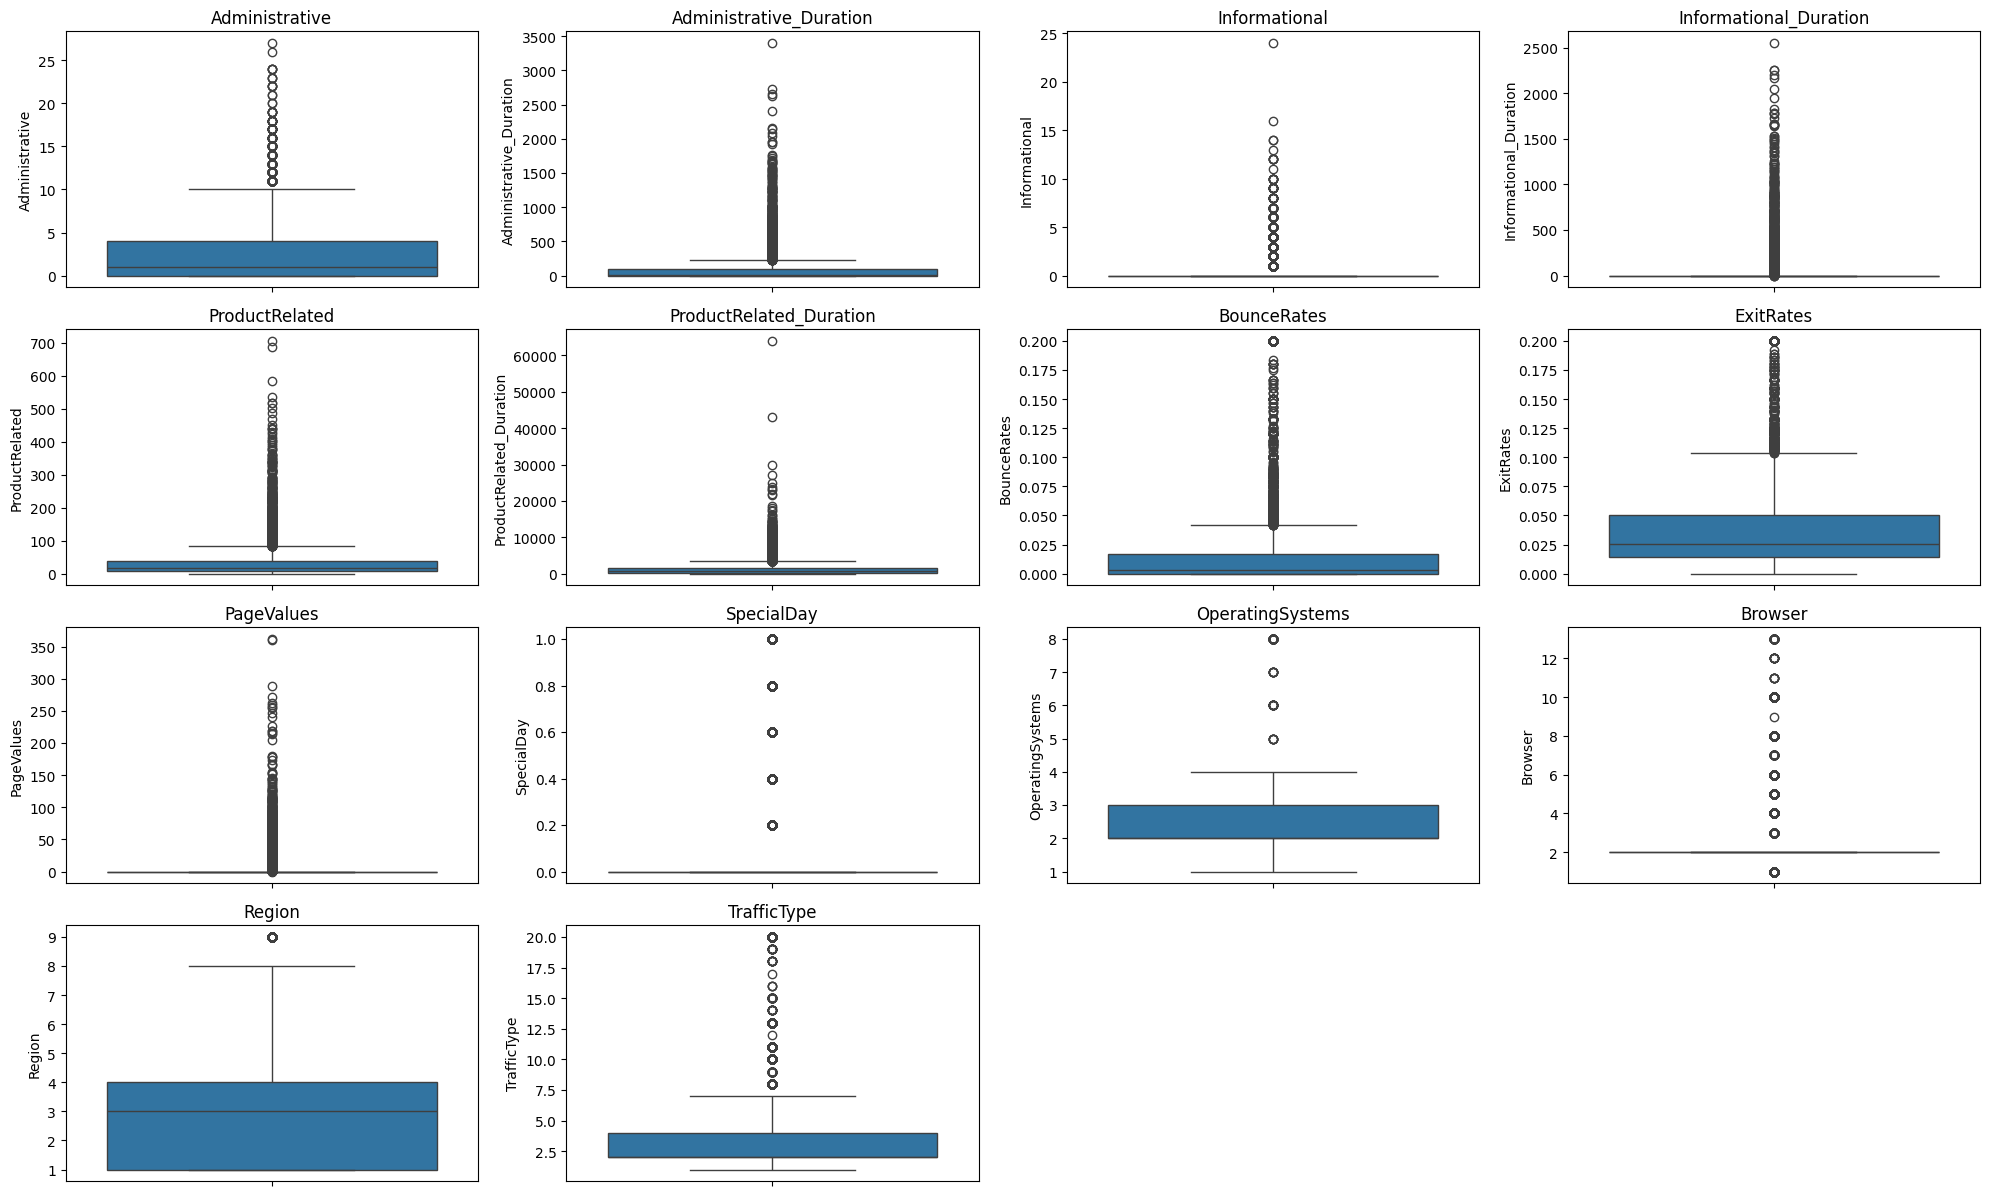

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

label_encoders = {}
for column in ['Month', 'VisitorType', 'Weekend']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 9864 samples
Testing set size: 2466 samples


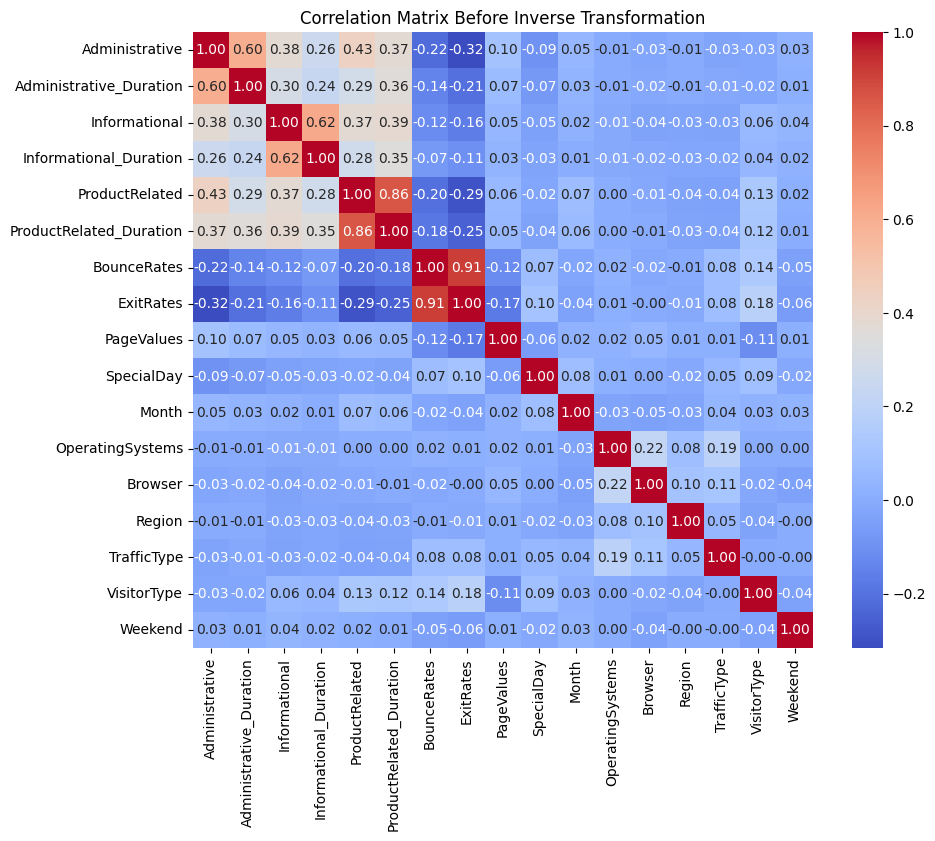

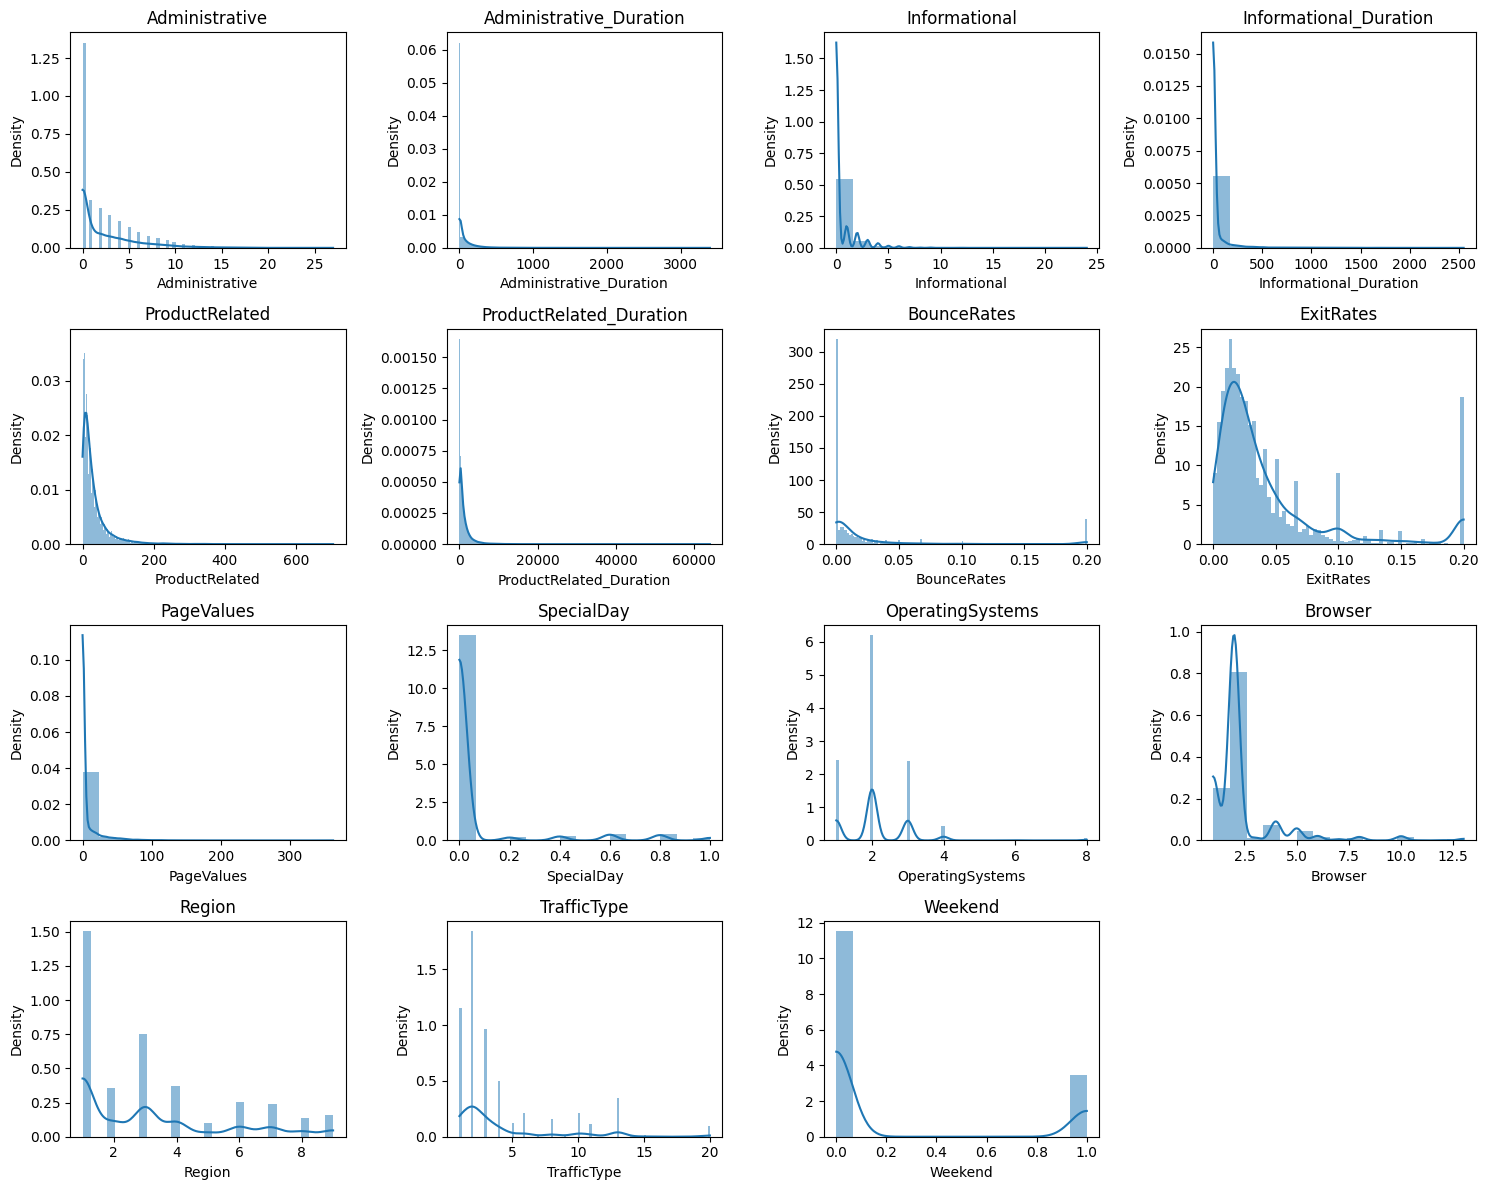

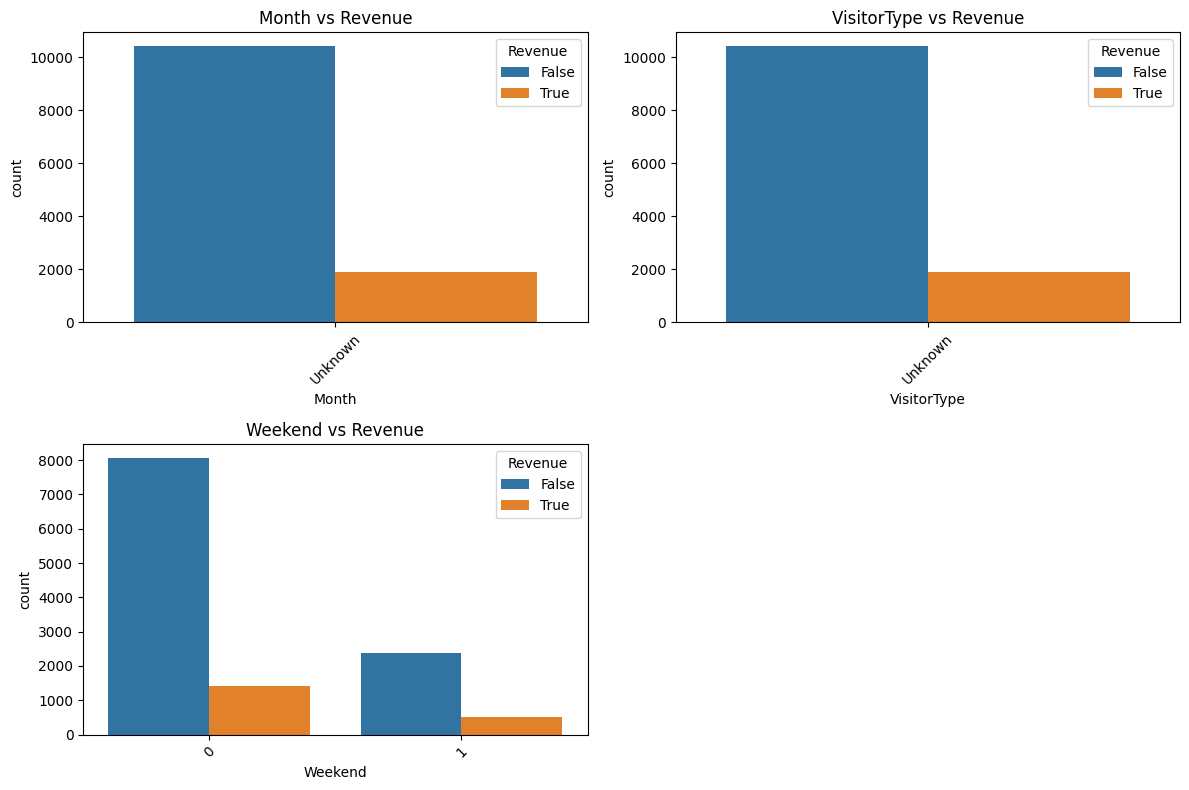

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import math

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before Inverse Transformation')
plt.show()

def safe_inverse_transform(le, series):
    inverse_mapping = {v: k for k, v in enumerate(le.classes_)}

    return series.apply(lambda x: inverse_mapping.get(x, 'Unknown'))

for column in ['Month', 'VisitorType', 'Weekend']:
    df[column] = safe_inverse_transform(label_encoders[column], df[column])

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
n_features = len(numerical_features)
cols = 4
rows = math.ceil(n_features / cols)

plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df[col], kde=True, stat="density", linewidth=0)
    plt.title(col)
plt.tight_layout()
plt.show()

categorical_features = ['Month', 'VisitorType', 'Weekend']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, hue='Revenue', data=df)
    plt.title(f'{col} vs Revenue')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

selector = SelectFromModel(rf, prefit=True)
X_important_train = selector.transform(X_train)
X_important_test = selector.transform(X_test)

selected_features_mask = selector.get_support()

print("Selected features:", df.drop('Revenue', axis=1).columns[selected_features_mask])


Selected features: Index(['Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'ExitRates', 'PageValues'],
      dtype='object')


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

def evaluate_and_display_model_performance(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None


        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"


        print(f"{name}:")
        print(f" Accuracy: {accuracy:.4f}")
        print(f" Precision: {precision:.4f}")
        print(f" Recall: {recall:.4f}")
        print(f" F1 Score: {f1:.4f}")
        print(f" ROC AUC: {roc_auc if roc_auc != 'N/A' else 'Not Applicable (Model does not support probability estimates)'}\n")


evaluate_and_display_model_performance(models, X_important_train, X_important_test, y_train, y_test)



Logistic Regression:
 Accuracy: 0.8804
 Precision: 0.7514
 Recall: 0.3403
 F1 Score: 0.4685
 ROC AUC: 0.857388253559908

Decision Tree:
 Accuracy: 0.8504
 Precision: 0.5169
 Recall: 0.5209
 F1 Score: 0.5189
 ROC AUC: 0.7048510968636632

KNN:
 Accuracy: 0.8816
 Precision: 0.6520
 Recall: 0.5052
 F1 Score: 0.5693
 ROC AUC: 0.8304722593482128

Naive Bayes:
 Accuracy: 0.8589
 Precision: 0.5489
 Recall: 0.5000
 F1 Score: 0.5233
 ROC AUC: 0.8212898574026992



In [8]:
from sklearn.model_selection import GridSearchCV


param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
param_grid_dt = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
param_grid_nb = {}  # GaussianNB doesn't have relevant hyperparameters that are typically tuned


best_estimators = {}

grid_searches = {
    "Logistic Regression": GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy'),
    "Decision Tree": GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy'),
    "KNN": GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
    # Naive Bayes is not included due to the lack of common hyperparameters to tune.
}


for name, grid_search in grid_searches.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search.fit(X_important_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}\n")

# Adding Naive Bayes to best_estimators manually
best_estimators["Naive Bayes"] = GaussianNB()


Running GridSearchCV for Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best score for Logistic Regression: 0.8846305962131782

Running GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Best score for Decision Tree: 0.8822998409563592

Running GridSearchCV for KNN...
Best parameters for KNN: {'n_neighbors': 9, 'weights': 'uniform'}
Best score for KNN: 0.8900033309721813



In [9]:
evaluate_and_display_model_performance(best_estimators, X_important_train, X_important_test, y_train, y_test)


Logistic Regression:
 Accuracy: 0.8804
 Precision: 0.7514
 Recall: 0.3403
 F1 Score: 0.4685
 ROC AUC: 0.8572915305845584

Decision Tree:
 Accuracy: 0.8816
 Precision: 0.6424
 Recall: 0.5314
 F1 Score: 0.5817
 ROC AUC: 0.8200418797921838

KNN:
 Accuracy: 0.8848
 Precision: 0.6713
 Recall: 0.5026
 F1 Score: 0.5749
 ROC AUC: 0.8491988322898977

Naive Bayes:
 Accuracy: 0.8589
 Precision: 0.5489
 Recall: 0.5000
 F1 Score: 0.5233
 ROC AUC: 0.8212898574026992



In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score


knn_best = best_estimators['KNN']


roc_auc_scores = cross_val_score(knn_best, X_important_train, y_train, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True))

print(f"Cross-validated ROC AUC scores: {roc_auc_scores}")
print(f"Average ROC AUC score: {roc_auc_scores.mean()}")


Cross-validated ROC AUC scores: [0.85799229 0.88902976 0.8679119  0.85615524 0.85998702]
Average ROC AUC score: 0.866215242601147


In [11]:
from sklearn.metrics import roc_curve, auc, classification_report
import numpy as np

y_scores = knn_best.predict_proba(X_important_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))


ROC AUC: 0.8491988322898977
Optimal Threshold: 0.2222222222222222
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      2084
           1       0.47      0.78      0.58       382

    accuracy                           0.83      2466
   macro avg       0.71      0.81      0.74      2466
weighted avg       0.88      0.83      0.84      2466

